# Assessment of NPS Quiet Pavement data

This notebook carries out exploratory data analysis on the quiet pavement study data. There are two types of data considered:

- OBSI: Onboard sound intensity measurement from a fixed instrument on a measurement vehicle, traveling at 45 mph
- Passby: Road way observational data, where speed and vehicle type vary.

There are eight sites, and four pavement treatments; each pavement treatment is replicated at two sites. Sound intensity was measured pre-treatment aand post-treatment.

In the original assessment, overall the Type II microsurfacing was found to reduce overall sound intensity sound from OBSI measuremnts from 99.2 dB on average to 97.6. Other treatments did not on average reduce sound levels. 

The source data is `Data Summary QP Re-Analysis.xlsx` from 2019-06-13.

## Questions

1. The All Passby sheet seems wrong. It only has S07 measurements from 2016, and the un-dated measurements (assumed to be post-treatment) are only S01-S04. Where are the other pre-treatment data (besides S07) and the other post-treatment data (besides S01-04)?

2. Are `airTemp` and `pavetemp` available for post-treamtent passby data?


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from cycler import cycler

OBSI DATA

In [104]:
#Transform OBSI into column form, basic dataframe
OBSI = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis.xlsx", sheet_name = "ALL OBSI", header = 1).T
OBSI.rename_axis(None,axis=1, inplace = True)
OBSI.drop([0,4], axis = 1, inplace = True)
OBSI.columns = OBSI.iloc[0]
OBSI = OBSI[1:]
OBSI.reset_index(inplace = True)
OBSI.drop(["index"], axis = 1, inplace = True)
OBSI.columns.name = None
#Adds pavement type into dataframe
#Turn values into a lists if you want to add other metadata
pavement_type = {
    1: "3/8in Chip Seal",
    2: "1/4in Chip Seal",
    3: "Type II Microsurfacing",
    4: "Type III Microsurfacing",
    5: "3/8in Chip Seal",
    6: "Type III Microsurfacing",
    7: "Type II Microsurfacing",
    8: "1/4in Chip Seal"
}
OBSI["Pavement Type"]=[pavement_type[s] for s in OBSI["Site"]]

macro_pavement_type = {
    1: "Chip Seal",
    2: "Chip Seal",
    3: "Microsurfacing",
    4: "Microsurfacing",
    5: "Chip Seal",
    6: "Microsurfacing",
    7: "Microsurfacing",
    8: "Chip Seal"
}
OBSI["Macro Pavement Type"]=[macro_pavement_type[s] for s in OBSI["Site"]]
OBSI["Site"] = OBSI["Site"].astype(str)

In [146]:
#Group data by year, site, pavement type, and replicates
OBSI_grouped = OBSI.set_index(["Measurement Year", "Site", "Pavement Type","Replicates", "Macro Pavement Type"])
OBSI_grouped= OBSI_grouped.swaplevel("Pavement Type", "Site") # Use this to swap levels
OBSI_grouped.sort_index(inplace=True)
OBSI_grouped = OBSI_grouped.astype(float)

Index([          250,           315,           400,           500,
                 630,           800,          1000,          1250,
                1600,          2000,          2500,          3150,
                4000,          5000, 'Overall SIL'],
      dtype='object')
250
315
400
500
630
800
1000
1250
1600
2000
2500
3150
4000
5000
Overall SIL


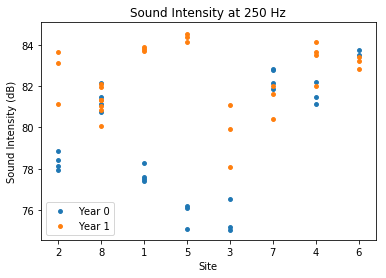

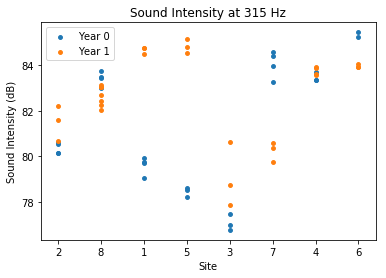

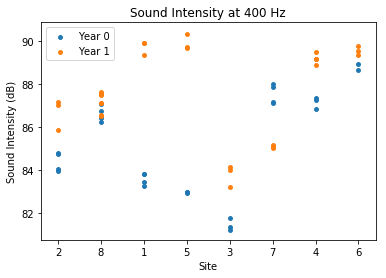

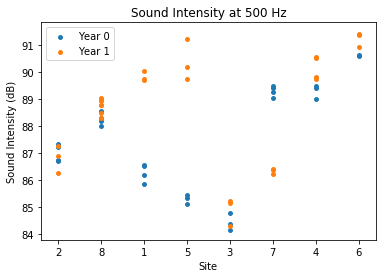

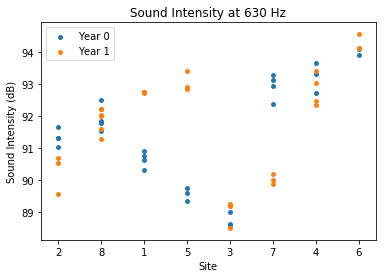

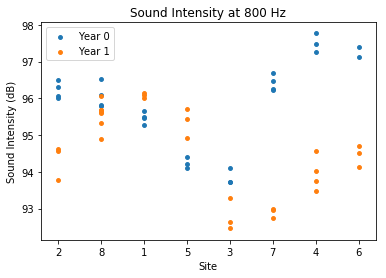

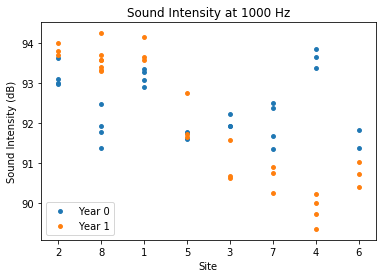

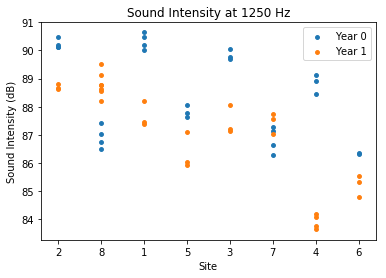

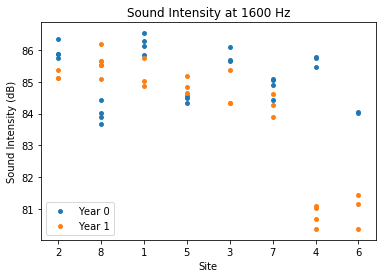

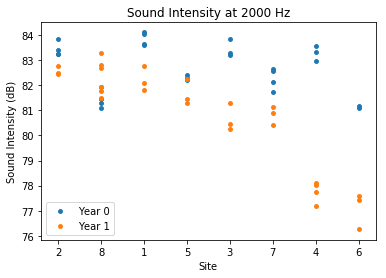

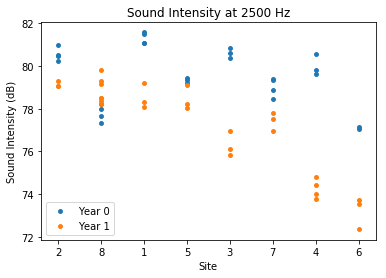

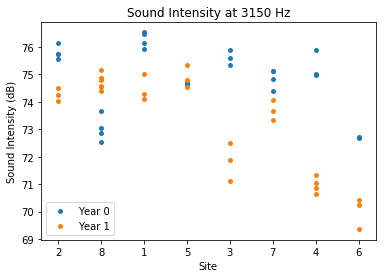

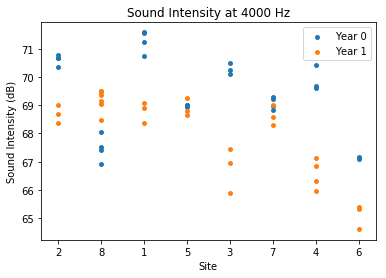

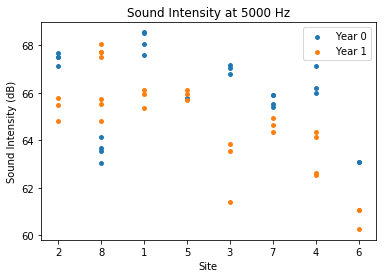

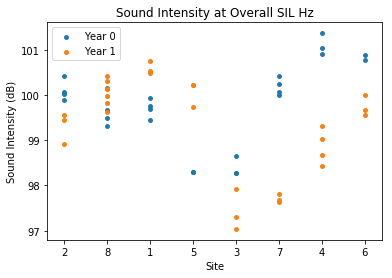

In [139]:
# Plot data by site and sound intensity. Each figure is a different frequency
# Last column describes pavement treatment type
# Blue = pre-treatment, Orange = post treatment.

# 2, 8: 1/4 inch chip seal
# 1, 5: 3/4 inch chip seal
# 3, 7: Type II Microsurfacing
# 4, 6: Type III Microsurfacing

#Separate data by year and use sites sorted by pavement type for plotting
yr0OBSI = OBSI_grouped.groupby(level = 0).get_group(0)
yr1OBSI = OBSI_grouped.groupby(level = 0).get_group(1)

for freq in yr0OBSI.columns:
    plt.figure()
    plt.scatter(yr0OBSI.index.get_level_values("Site"), yr0OBSI[freq], s = 15, label = "Year 0")
    plt.scatter(yr1OBSI.index.get_level_values("Site"), yr1OBSI[freq], s = 15, label = "Year 1")
    plt.title("Sound Intensity at " + str(freq) + " Hz")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.legend() # Only shows freq; how do we get it to follow arguments from plt.scatter? 
#     plt.ylim(58,105)

In [5]:
# OBSI # Uncomment to see entire data frame

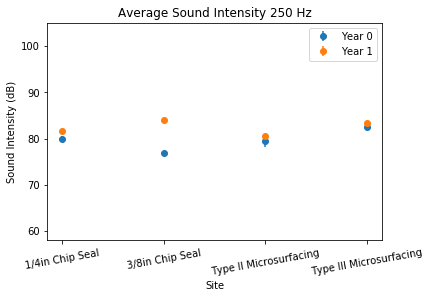

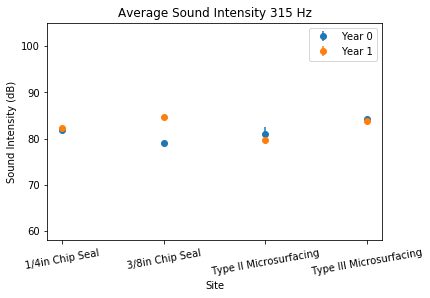

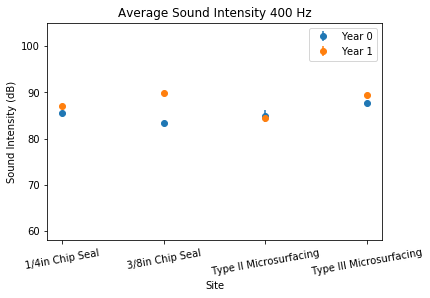

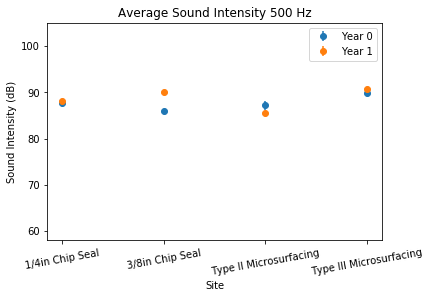

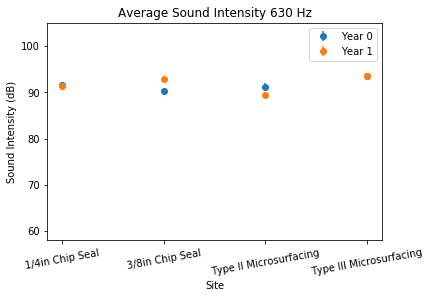

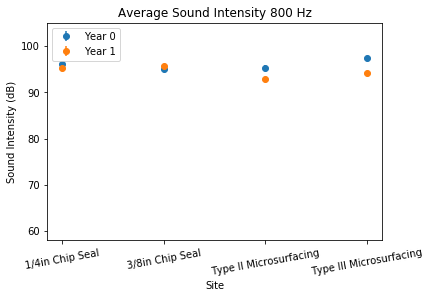

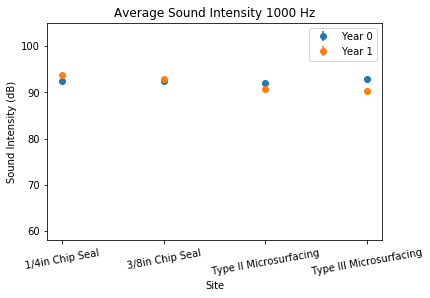

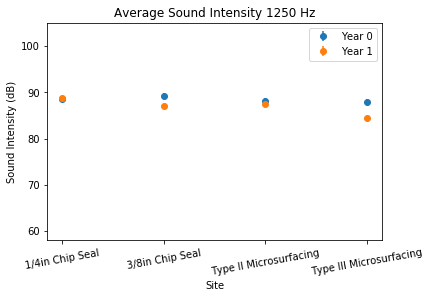

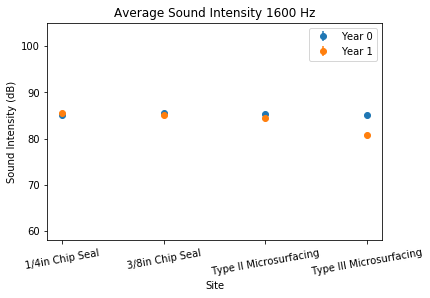

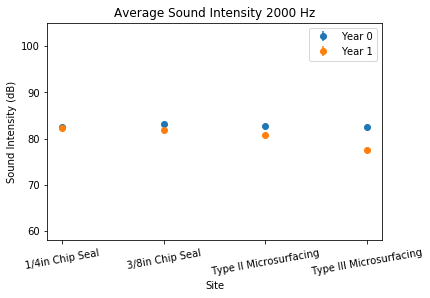

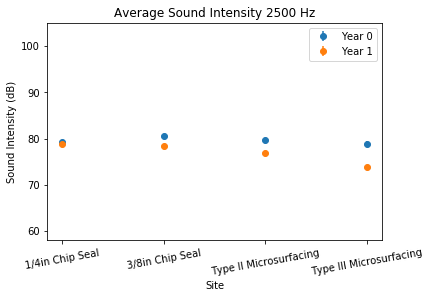

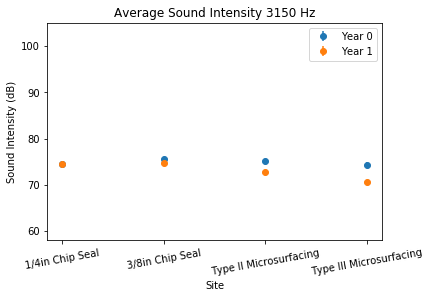

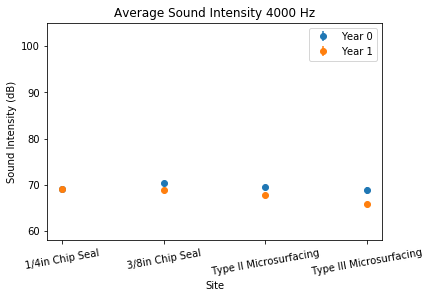

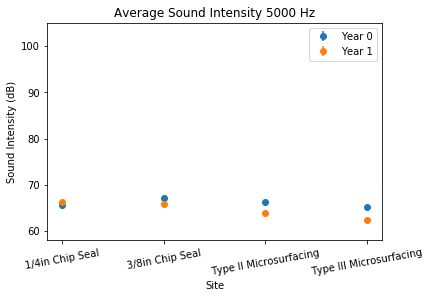

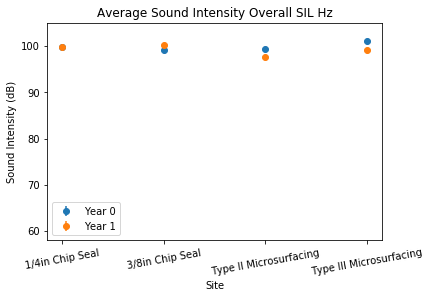

In [150]:
# Mean grouped by year and site
OBSI_mean_by_site = OBSI_grouped.groupby(level = [0,1]).mean()
OBSI_yearly_sem = OBSI_grouped.groupby(level = [0,1]).sem()
#Plot data by site and sound intensity averaged and separated by year
for freq in OBSI_mean_by_site.columns:
    plt.figure()
    
    plt.errorbar(OBSI_mean_by_site.loc[0].index,OBSI_mean_by_site.loc[0][freq], 
                OBSI_yearly_sem.loc[0][freq], ls = "None",marker = ".", ms= 12, label = "Year 0")
    
    plt.errorbar(OBSI_mean_by_site.loc[1].index,OBSI_mean_by_site.loc[1][freq],
                OBSI_yearly_sem.loc[1][freq], ls = "None",marker = ".", ms = 12, label = "Year 1")
    
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
    plt.xticks(rotation = 10)
    plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

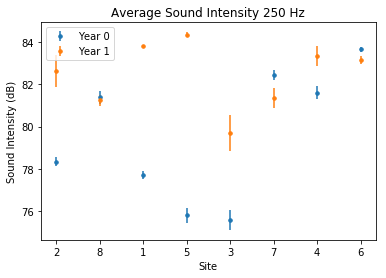

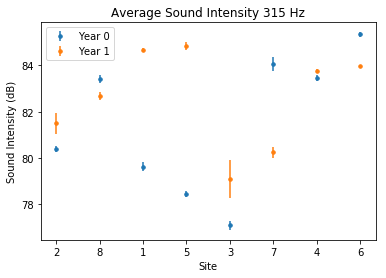

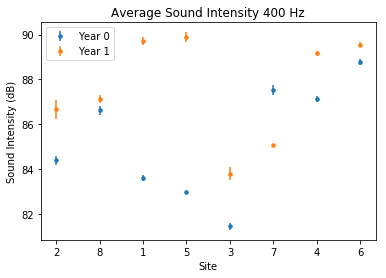

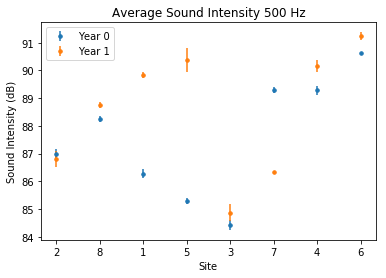

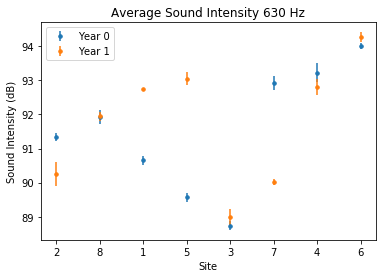

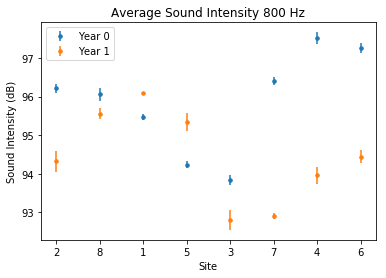

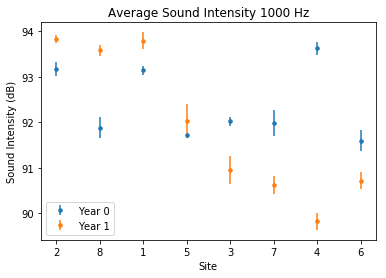

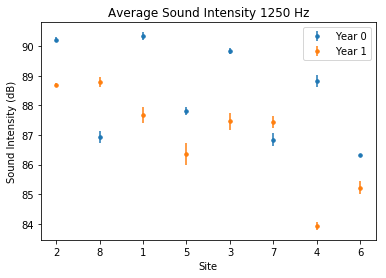

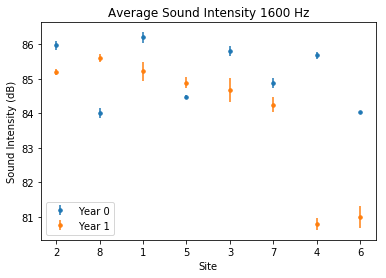

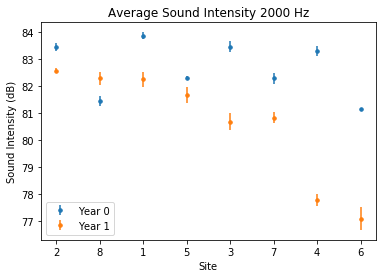

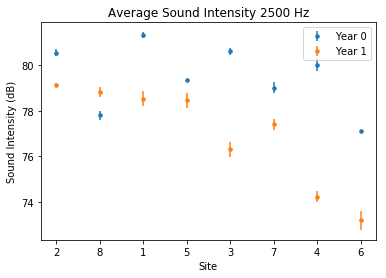

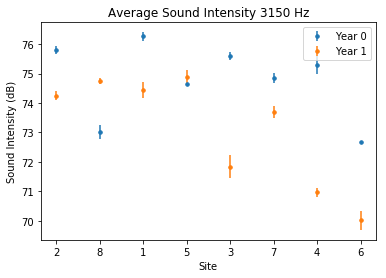

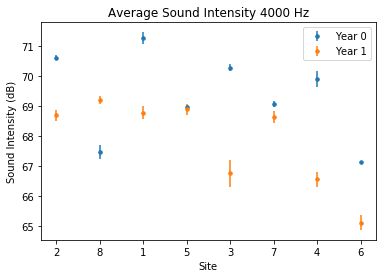

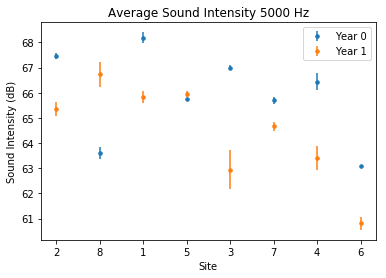

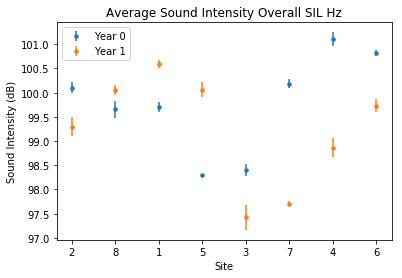

In [203]:
# Mean grouped by year and pavement type

# 2, 8: 1/4 inch chip seal
# 1, 5: 3/4 inch chip seal
# 3, 7: Type II Microsurfacing
# 4, 6: Type III Microsurfacing

#Take grouped means across replicates and macro pavement type
#Year, pavement type, and site presevered
OBSI_mean_by_pavement = OBSI_grouped.groupby(level = [0,1,2]).mean()
OBSI_sem_by_pavement = OBSI_grouped.groupby(level = [0,1,2]).sem()

#Get dataframes of each year
year0_mean = OBSI_mean_by_pavement.loc[(0)]
year1_mean = OBSI_mean_by_pavement.loc[(1)]

#PLOT
for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    
    plt.errorbar(year0_mean.index.get_level_values(1) ,year0_mean[freq], 
                OBSI_sem_by_pavement.loc[0][freq], ls = "None",marker = ".", ms= 7, label = "Year 0")
    
    plt.errorbar(year1_mean.index.get_level_values(1),year1_mean[freq],
                OBSI_sem_by_pavement.loc[1][freq], ls = "None",marker = ".", ms = 7, label = "Year 1")
    
    plt.legend()
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

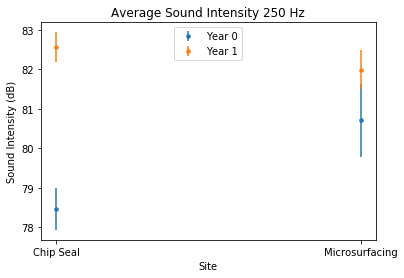

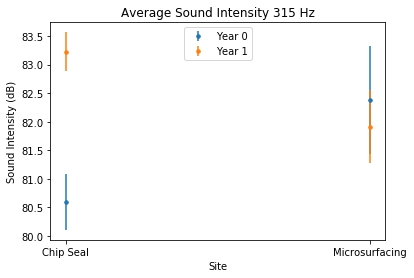

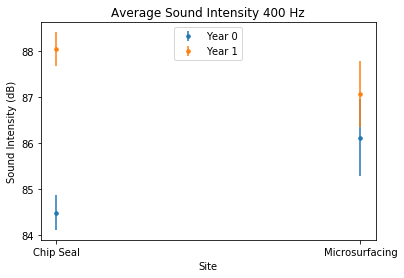

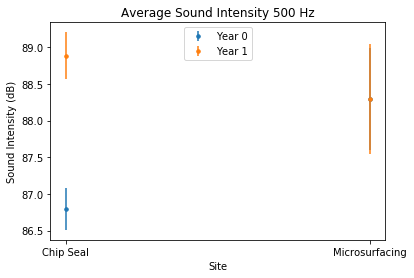

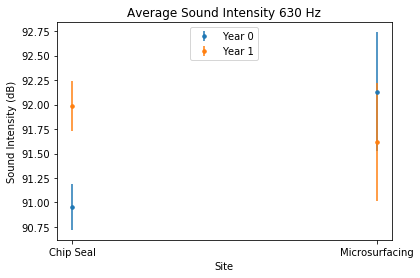

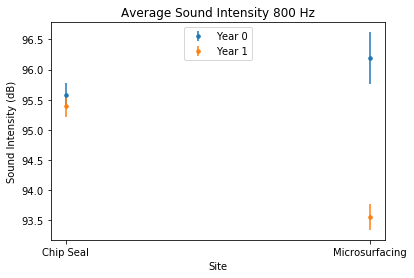

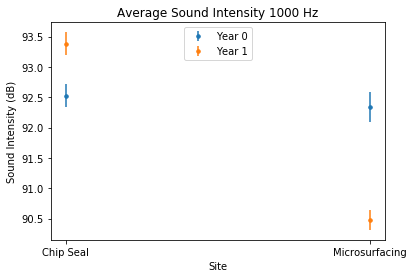

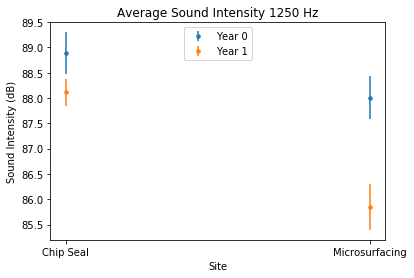

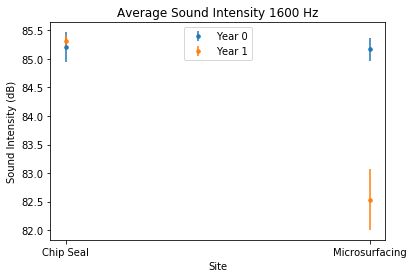

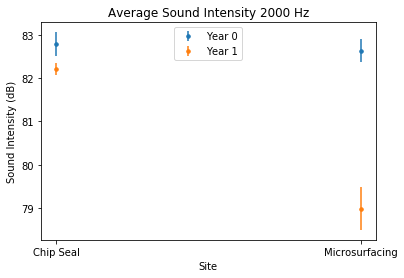

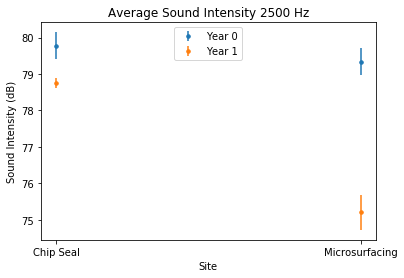

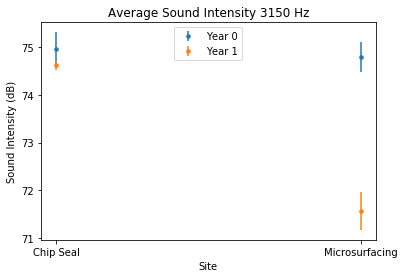

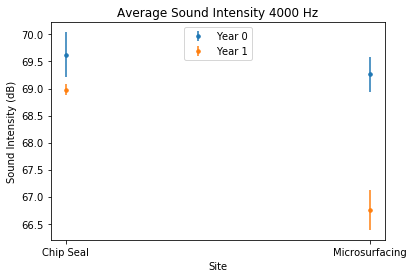

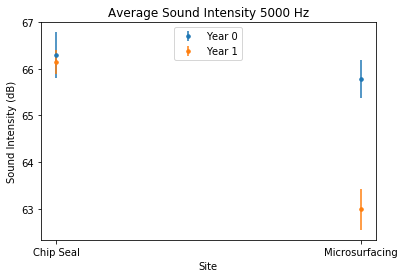

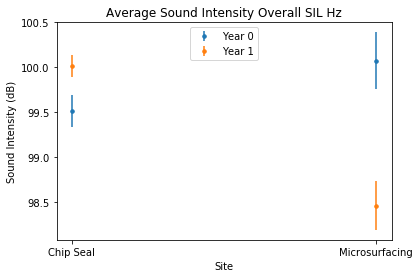

In [220]:
# Mean grouped by macro pavement types, chip seal and microsurfacing

#Take grouped means across pavement type, replicates, and site
#Year and macro pavement type preserved
OBSI_mean_by_macro = OBSI_grouped.groupby(level = [0,4]).mean()
OBSI_sem_by_macro = OBSI_grouped.groupby(level = [0,4]).sem()

#Get dataframes of each year
year0_mean = OBSI_mean_by_macro.loc[(0)]
year1_mean = OBSI_mean_by_macro.loc[(1)]

#PLOT
for freq in OBSI_mean_by_pavement.columns:
    plt.figure()
    
    plt.errorbar(year0_mean.index ,year0_mean[freq], 
                OBSI_sem_by_macro.loc[0][freq], ls = "None",marker = ".", ms= 7, label = "Year 0")
    
    plt.errorbar(year1_mean.index, year1_mean[freq],
                OBSI_sem_by_macro.loc[1][freq], ls = "None",marker = ".", ms = 7, label = "Year 1")
    
    plt.legend(loc = "upper center")
    plt.xlabel("Site")
    plt.ylabel("Sound Intensity (dB)")
#     plt.ylim(58,105)
    plt.title("Average Sound Intensity "+ str(freq) + " Hz")

In [8]:
#Count how many datapoints are in each grouping
OBSI_counts_by_site =OBSI_grouped.groupby(level = [0,1]).count()
OBSI_counts_by_pavement =OBSI_grouped.groupby(level = [0,2]).count()
OBSI_counts_by_pavement, OBSI_counts_by_site

(                       250  315  400  500  630  800  1000  1250  1600  2000  \
 Measurement Year Site                                                         
 0                1       4    4    4    4    4    4     4     4     4     4   
                  2       4    4    4    4    4    4     4     4     4     4   
                  3       3    3    3    3    3    3     3     3     3     3   
                  4       3    3    3    3    3    3     3     3     3     3   
                  5       3    3    3    3    3    3     3     3     3     3   
                  6       2    2    2    2    2    2     2     2     2     2   
                  7       4    4    4    4    4    4     4     4     4     4   
                  8       4    4    4    4    4    4     4     4     4     4   
 1                1       3    3    3    3    3    3     3     3     3     3   
                  2       3    3    3    3    3    3     3     3     3     3   
                  3       3    3    3   

In [224]:
#Transform data to look at all frequences for each site
#Group data by site, year, and pavement type
OBSIfreq = OBSI_grouped.T

# OBSIfreq_mean_type = OBSIfreq[:14].groupby(level = [1],axis = 1).mean()
OBSIfreq_mean_site = OBSIfreq[:14].groupby(level = [2],axis = 1).mean()
OBSIfreq_mean_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).mean()
OBSIfreq_mean_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).mean()
OBSIfreq_mean_yr_macro = OBSIfreq[:14].groupby(level = [0,4],axis = 1).mean()

# OBSIfreq_sem_type = OBSIfreq[:14].groupby(level = [1],axis = 1).sem()
OBSIfreq_sem_site = OBSIfreq[:14].groupby(level = [2],axis = 1).sem()
OBSIfreq_sem_yr_type = OBSIfreq[:14].groupby(level = [0,1],axis = 1).sem()
OBSIfreq_sem_yr_site = OBSIfreq[:14].groupby(level = [0,2],axis = 1).sem()
OBSIfreq_sem_yr_macro = OBSIfreq[:14].groupby(level = [0,4],axis = 1).sem()

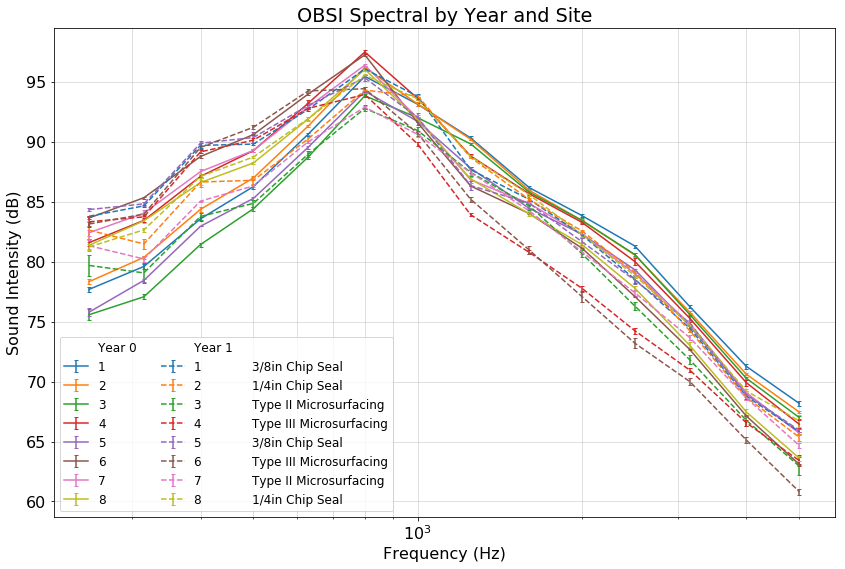

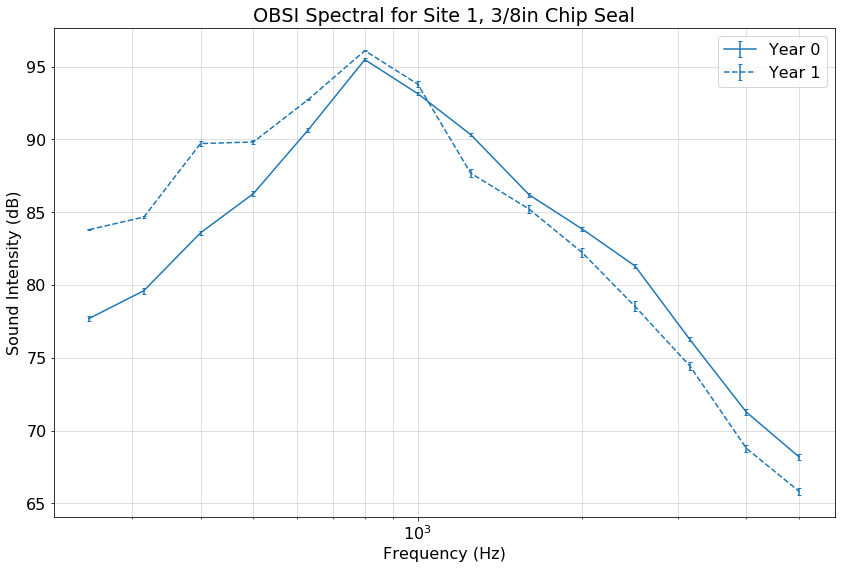

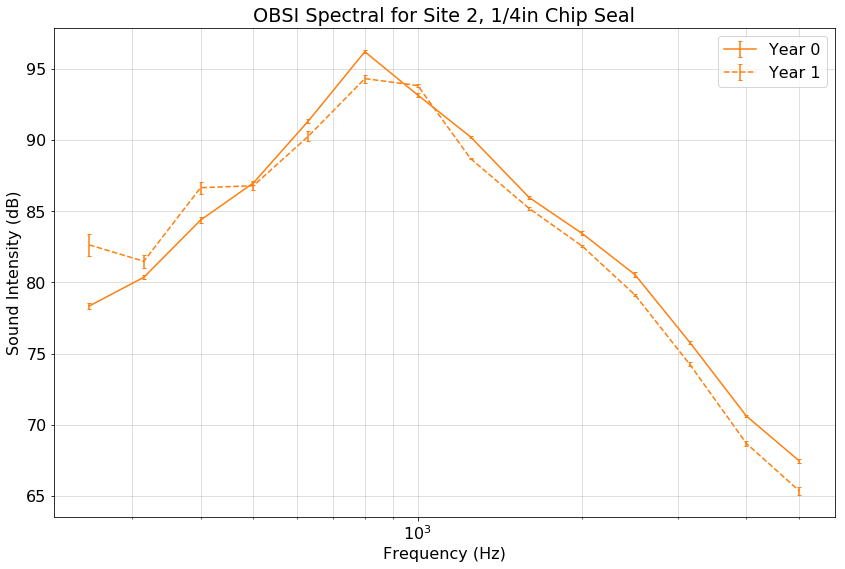

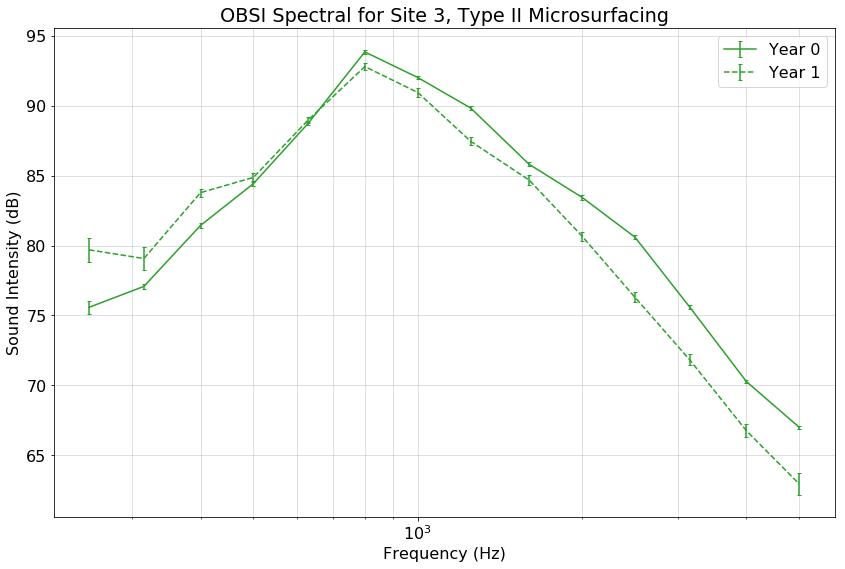

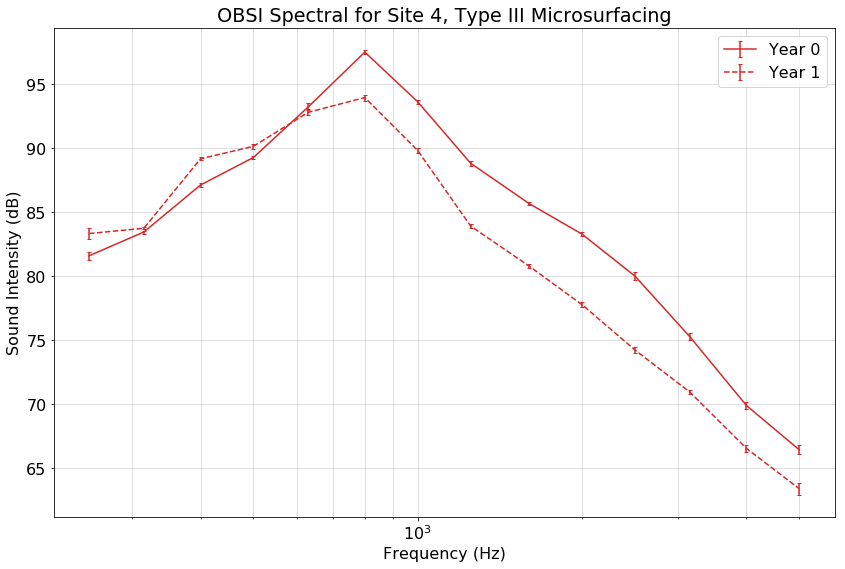

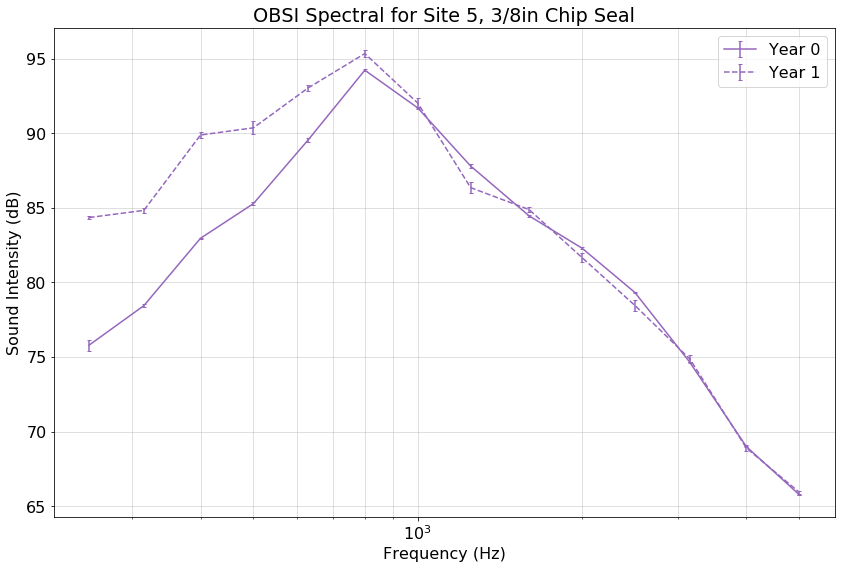

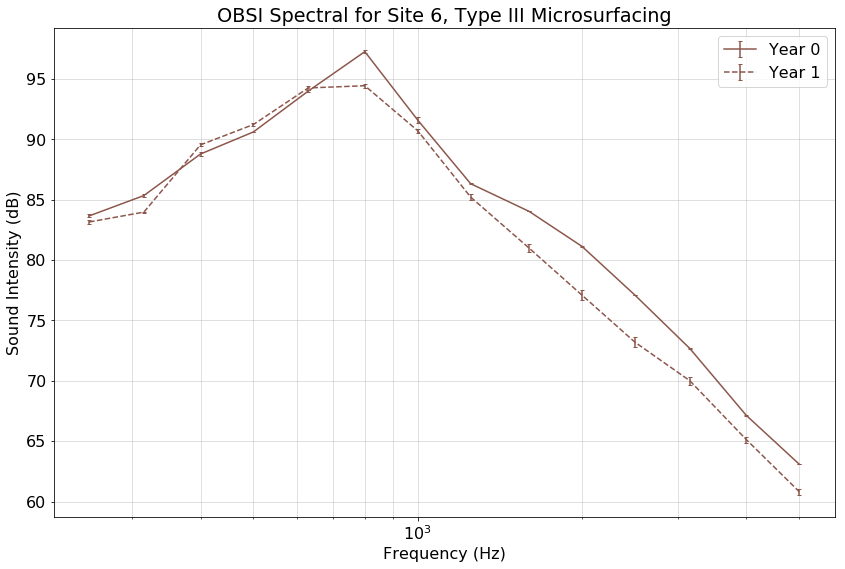

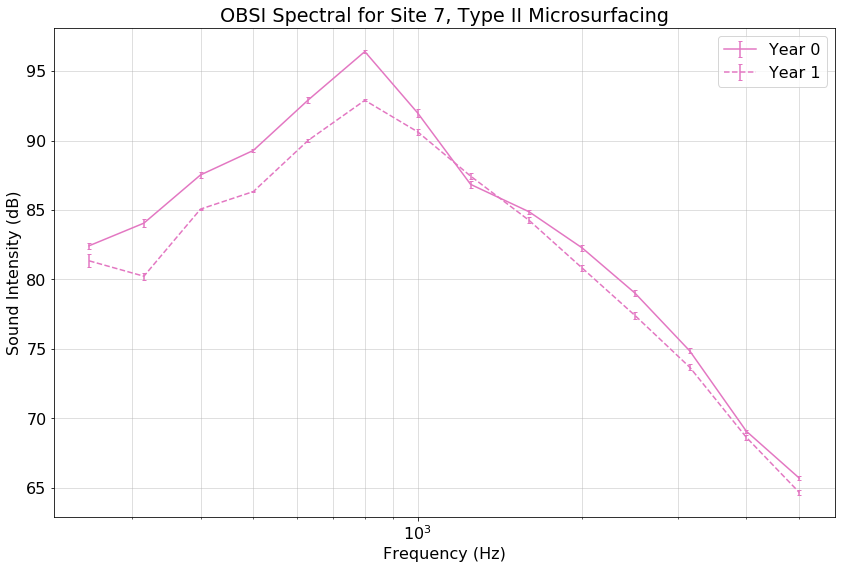

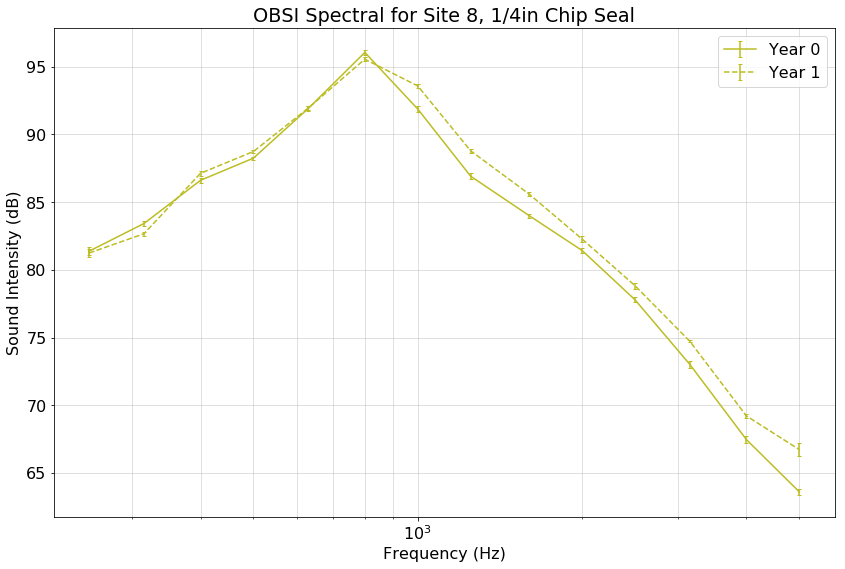

In [10]:
plt.figure(figsize = (14,9))
plt.rcParams.update({"font.size":16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728',
                                          '#9467bd','#8c564b','#e377c2', '#bcbd22'])))

for yr in [0,1]:
    for site in range(1,9):
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-")
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = str(site) + "             "+pavement_type[site])
            
h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]

plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12}, ncol = 2)
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Site")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site Comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2', '#bcbd22']
for site, col in zip(range(1,9), colors):
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "-", label = "Year 0", color = col)
        else:
            plt.errorbar(OBSIfreq_mean_yr_site.index, OBSIfreq_mean_yr_site[yr][site],OBSIfreq_sem_yr_site[yr][site],
                    capsize = 2, linestyle = "--", label = "Year 1", color = col)

    plt.legend()
    plt.grid(which = "both", alpha = 0.5)
    plt.title("OBSI Spectral for Site " + str(site) + ", " +pavement_type[site])
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")

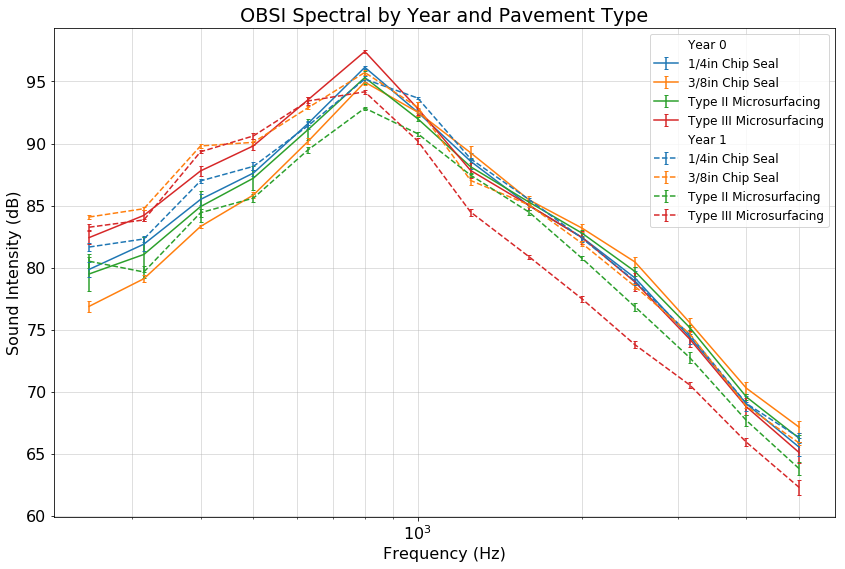

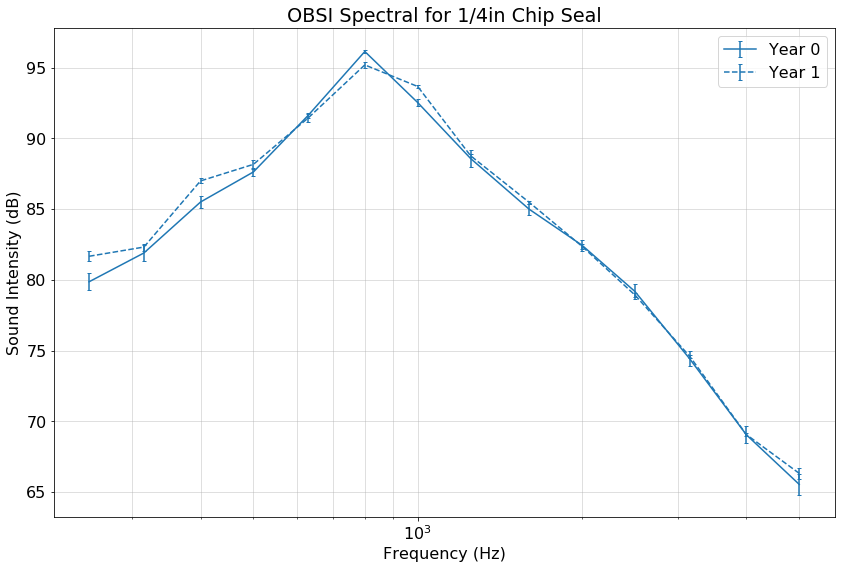

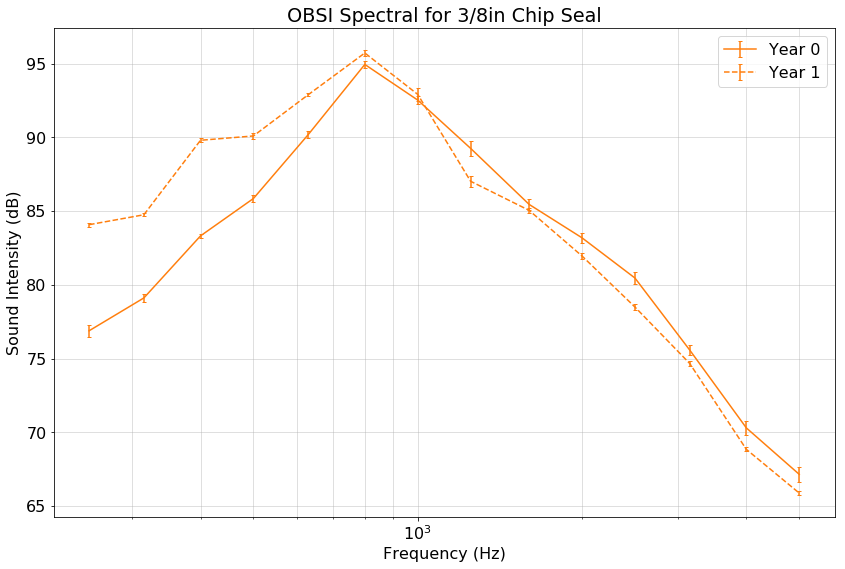

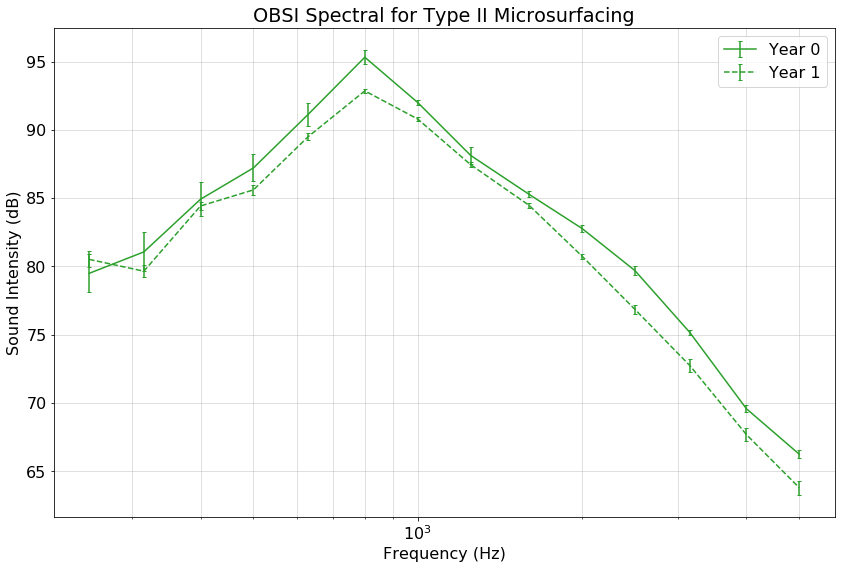

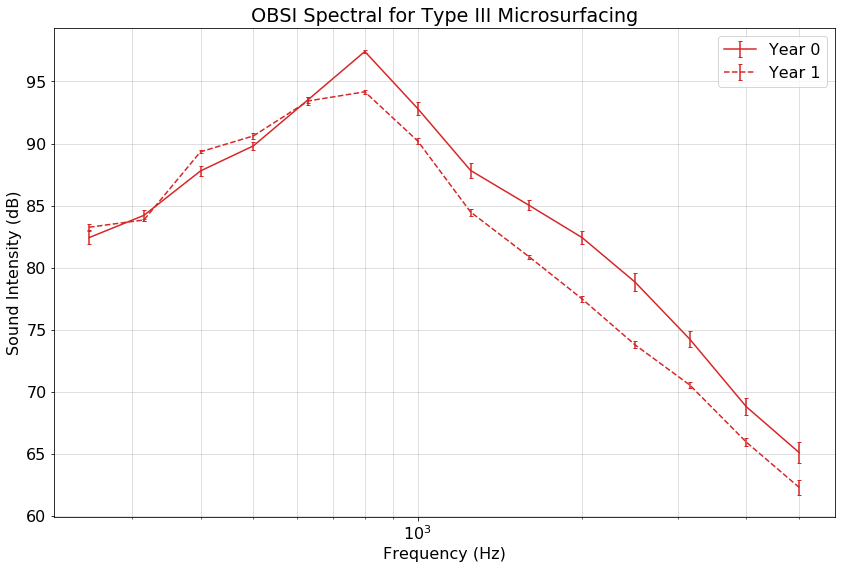

In [11]:
#Figures for Year and Pavement Type Grouping
plt.figure(figsize = (14,9))
plt.rcParams.update({'font.size': 16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e','#2ca02c','#d62728'])))
for yr in [0,1]:
    for ptype in OBSIfreq_mean_yr_type.columns.levels[1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2)
        else:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, linestyle = "--")

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]
plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12})
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Pavement Type")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site comparisons
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
for ptype, col in zip(OBSIfreq_mean_yr_type.columns.levels[1], colors):
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, color = col, label = "Year 0")
        else:
            plt.errorbar(OBSIfreq_mean_yr_type.index, OBSIfreq_mean_yr_type[yr][ptype],OBSIfreq_sem_yr_type[yr][ptype],
                    capsize = 2, linestyle = "--", color = col, label = "Year 1")
    plt.grid(which = "both", alpha = 0.5)
    plt.legend()
    plt.title("OBSI Spectral for " + ptype)
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")    

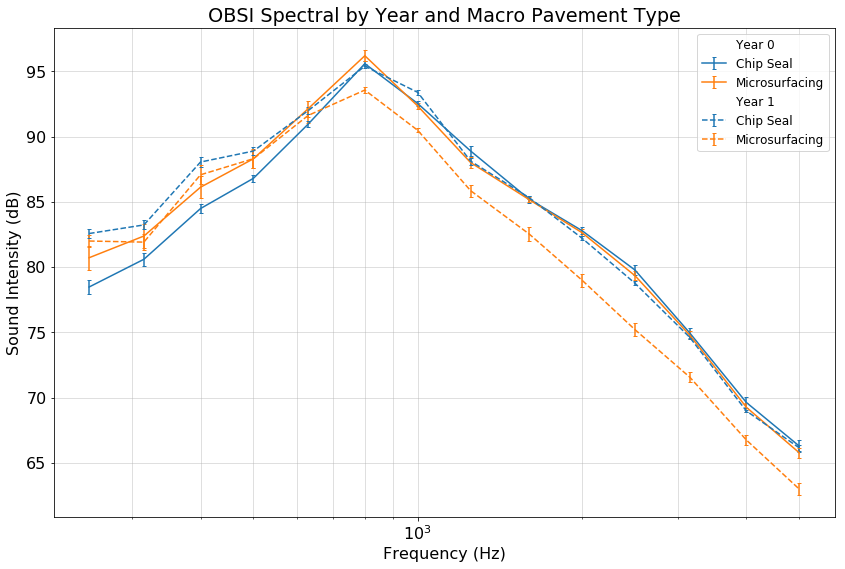

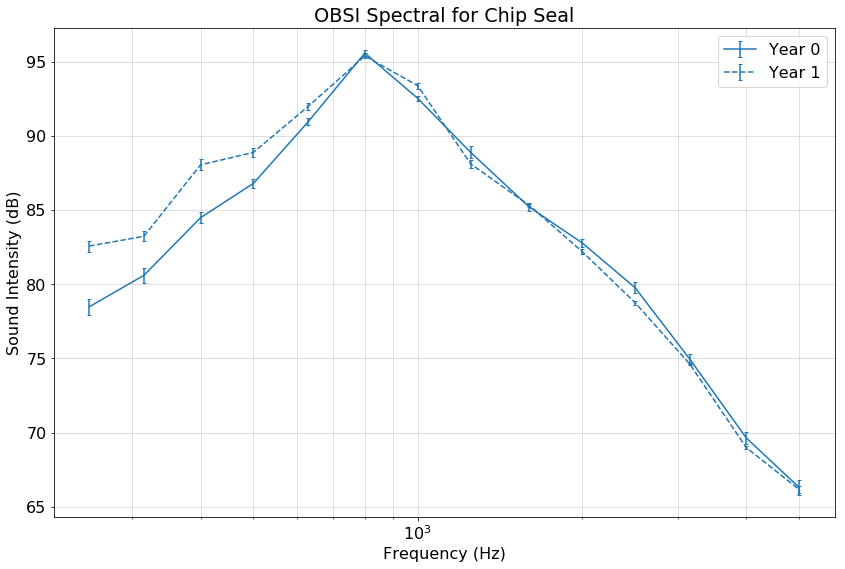

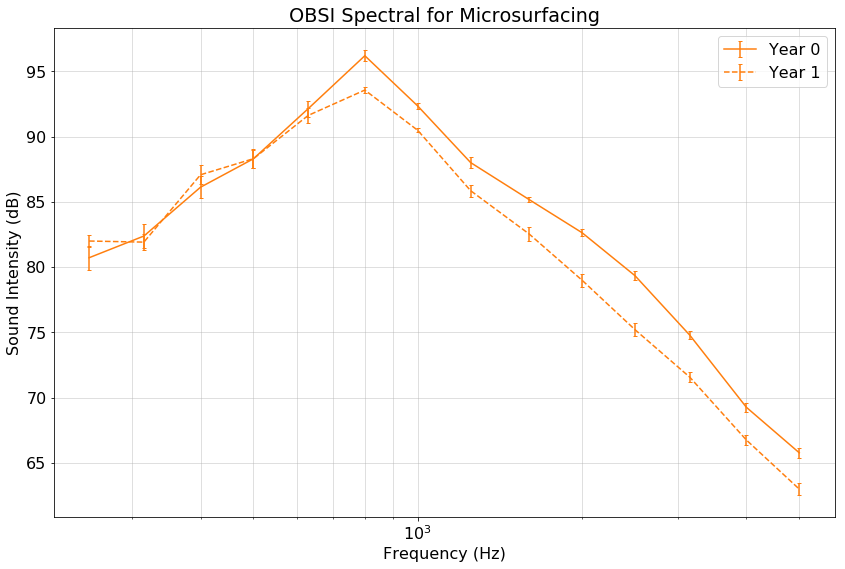

In [227]:
#Figures for Year and Macro Pavement Type Grouping
plt.figure(figsize = (14,9))
plt.rcParams.update({'font.size': 16})
plt.rc("axes", prop_cycle=(cycler('color',['#1f77b4','#ff7f0e'])))
for yr in [0,1]:
    for ptype in OBSIfreq_mean_yr_macro.columns.levels[1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                    capsize = 2)
        else:
            plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                    capsize = 2, linestyle = "--")

h, l = plt.gca().get_legend_handles_labels()
ph = [plt.plot([], marker = "", ls = "")[0]]
handles = ph + h[0:int(len(h)/2)]+ ph+ h[int(len(h)/2):]
labels = ["Year 0"]+l[0:int(len(h)/2)]+["Year 1"]+l[int(len(h)/2):]
plt.grid(which = "both", alpha = 0.5)
plt.legend(handles, labels,  prop={'size': 12})
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral by Year and Macro Pavement Type")
plt.xscale("log")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")

#Site comparisons
colors = ['#1f77b4','#ff7f0e']
for ptype, col in zip(OBSIfreq_mean_yr_macro.columns.levels[1], colors):
    plt.figure(figsize = (14,9))
    for yr in [0,1]:
        if yr == 0:
            plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                    capsize = 2, color = col, label = "Year 0")
        else:
            plt.errorbar(OBSIfreq_mean_yr_macro.index, OBSIfreq_mean_yr_macro[yr][ptype],OBSIfreq_sem_yr_macro[yr][ptype],
                    capsize = 2, linestyle = "--", color = col, label = "Year 1")
    plt.grid(which = "both", alpha = 0.5)
    plt.legend()
    plt.title("OBSI Spectral for " + ptype)
    plt.xscale("log")
    plt.ylabel("Sound Intensity (dB)")
    plt.xlabel("Frequency (Hz)")    

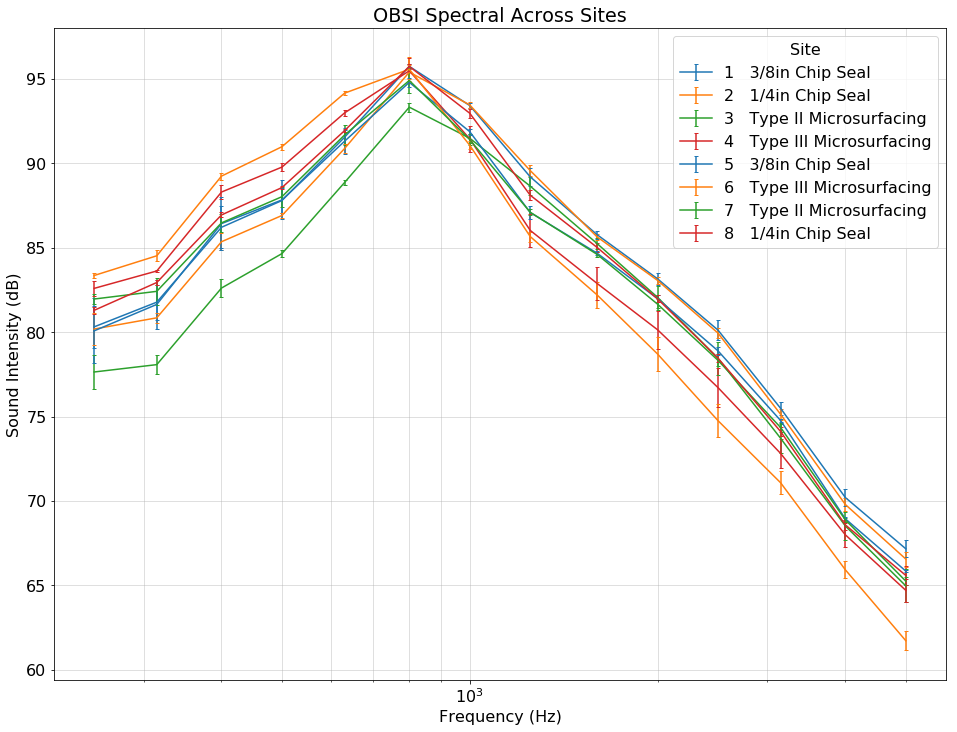

In [12]:
#Figures for site grouping
plt.figure(figsize = (16,12))
plt.rcParams.update({'font.size': 16})
for site in OBSIfreq_mean_site.columns:
    plt.errorbar(OBSIfreq_mean_site.index, OBSIfreq_mean_site[site], OBSIfreq_sem_site[site],
                capsize = 2, label = str(site) + "   "+pavement_type[site])
plt.xscale("log")
plt.grid(which = "both", alpha = 0.5)
plt.title("OBSI Spectral Across Sites")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.legend(title = "Site")

ALL PASSBY DATA

In [412]:
#Processes allpassby data, turns two row header into one row header as a tuple
allpassby = pd.read_excel("C:\\Quiet_Pavement_Local\\Data Summary QP Re-Analysis_rev2019 data.xlsx", sheet_name="All Passby", header =0)
allpassby.dropna(axis = 0, how = "all",inplace = True)
allpassby.dropna(axis = 1, how = "all", inplace = True)

allpassby["Pavement Type"] = ["Pavement Type"]+[pavement_type[float(s[2])] for s in allpassby["Unnamed: 2"][1:]]

# Remove rows with non-number speed values
allpassby = allpassby[pd.concat([pd.Series([True]), allpassby.applymap(np.isreal)["Unnamed: 7"][1:]])]
# Remove rows with nan speed values
allpassby = allpassby[pd.concat([pd.Series([True]),~allpassby["Unnamed: 7"][1:].isnull()])]

allpassby["Macro Pavement Type"] = ["Macro Pavement Type"]+[macro_pavement_type[float(s[2])] for s in allpassby["Unnamed: 2"][1:]]
allpassby.set_index(["Unnamed: 0","Macro Pavement Type", "Unnamed: 2", "Pavement Type"], inplace = True)

# Drop date, passtime, halfstep, vehtype, clean, Comment, winddir,
# cloud, ParkName, SiteName (the second one), and IntTemp
#These columns are either irrelevant, only exist for site 07, or are empty
allpassby.drop(["Unnamed: 1","Unnamed: 3","Unnamed: 4","Unnamed: 5","Unnamed: 6",
                "Unnamed: 8","Unnamed: 12","Unnamed: 13","Unnamed: 15","Unnamed: 16", "Unnamed: 22"], axis = 1, inplace = True)

# Drop accidentally copy/pasted frequency data
droplist = []
for i in range(97,133):
    droplist.append("Unnamed: "+str(i))
allpassby.drop(droplist, axis = 1, inplace = True)

#Create multilevel columns
header_corrections = []
for a,b in zip(allpassby.loc["Meas Year"].values.tolist()[0], allpassby.columns.tolist()):
    if isinstance(a,float):
        if "1/3 LZFeq" in b:
            header_corrections.append("1/3 LZFeq")
        else:
            header_corrections.append("1/3 LZFmax")
    else:
        header_corrections.append(a)
allpassby.columns = [header_corrections, allpassby.loc["Meas Year"].values.tolist()[0]]

#Remove column labels that are still inside the table
allpassby.drop([("Meas Year", "Macro Pavement Type", "sitename", "Pavement Type")],axis = 0, inplace = True)

C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  if sys.path[0] == '':
C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  del sys.path[0]


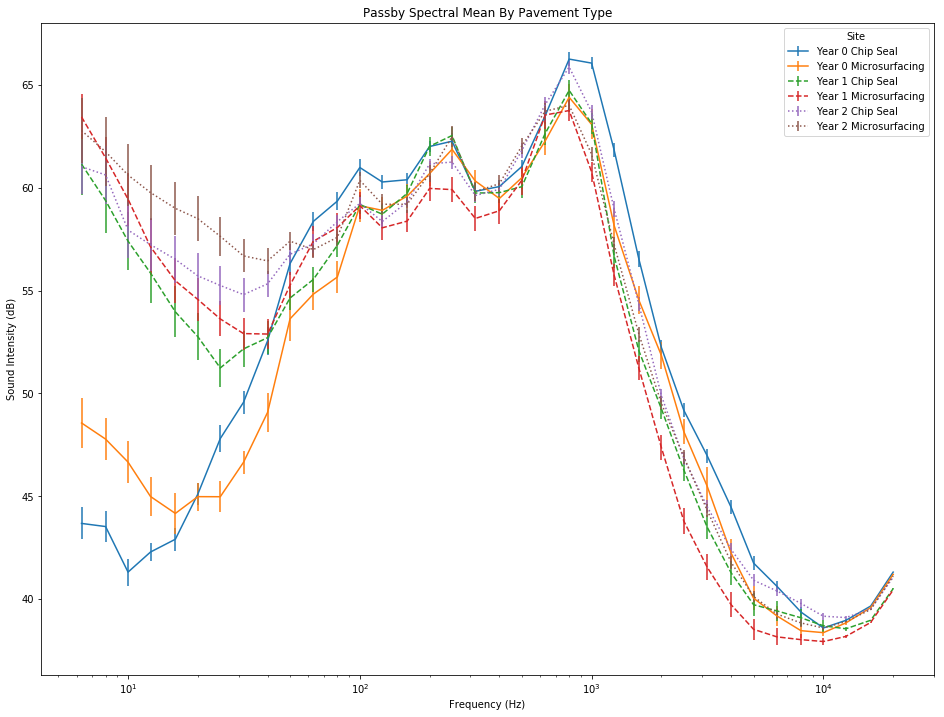

C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:47: PerformanceWarning: indexing past lexsort depth may impact performance.
C:\Users\Janice.Shiu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:48: PerformanceWarning: indexing past lexsort depth may impact performance.


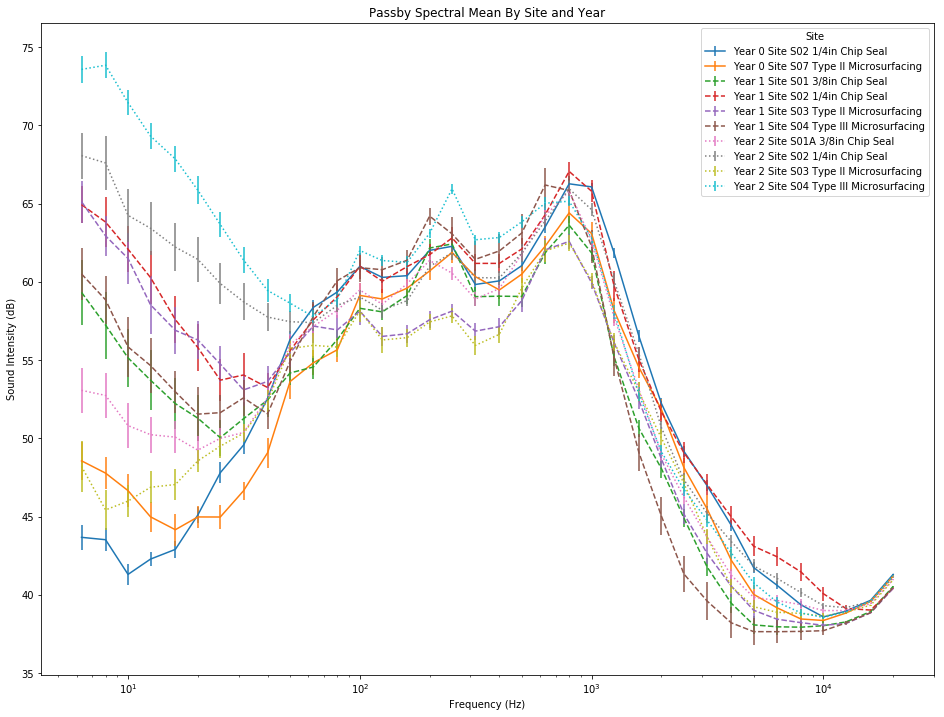

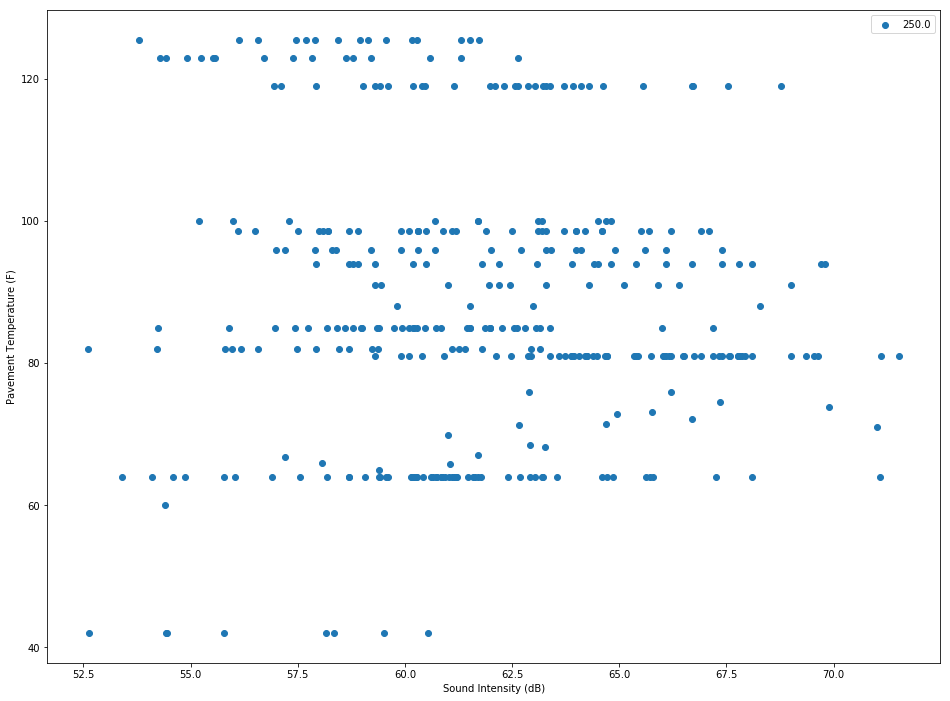

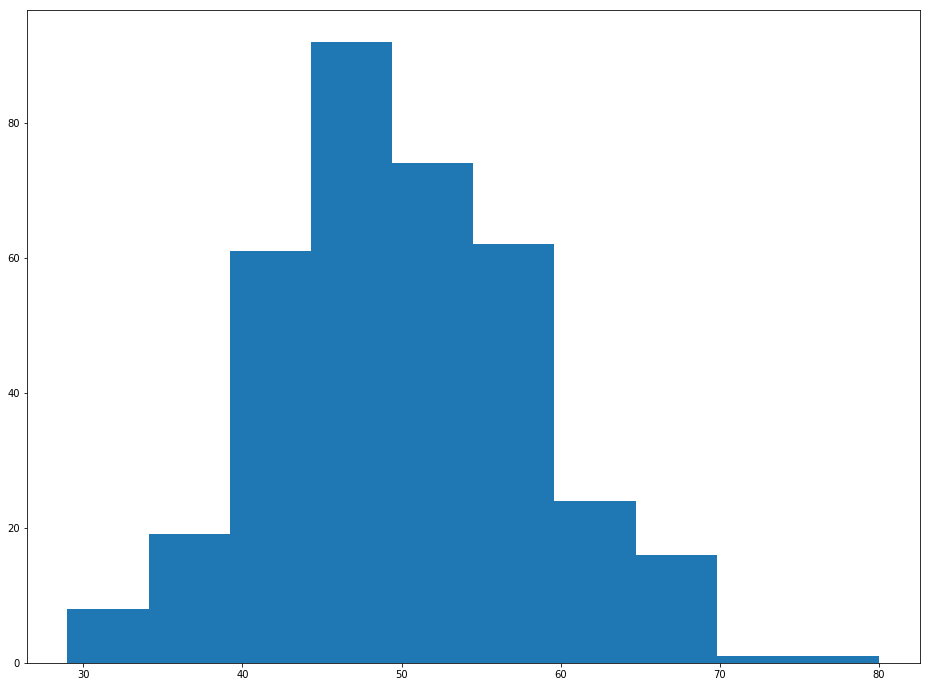

In [424]:
frequencies = allpassby["1/3 LZFeq"]
speed = allpassby["speed"]
pavetemp = allpassby["pavetemp"]

plt.figure(figsize = (16,12))
#iterate through years
for yr in allpassby.index.levels[0]:
    for macro in allpassby.index.levels[1]:
        if yr != "Meas Year" and macro != "Macro Pavement Type":

            try:
                mean = frequencies.loc[(yr, macro)].mean()
                sem = frequencies.loc[(yr, macro)].sem()
                if yr == 0:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "-",
                                 label = "Year " + str(yr) + " "+ macro)
                elif yr == 1:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "--",
                                 label = "Year " + str(yr) + " "+ macro)
                elif yr == 2:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = ":",
                                 label = "Year " + str(yr) + " "+ macro)

            except:
                continue
plt.title("Passby Spectral Mean By Pavement Type")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.legend(title = "Site")
plt.show()


#switch levels to look exclusively at year and site
allpassby_swapped = allpassby.copy().swaplevel(1,2)
frequencies = allpassby_swapped["1/3 LZFeq"]
speed = allpassby_swapped["speed"]
pavetemp = allpassby_swapped["pavetemp"]

#Mean sound intensity figures across all sites
plt.figure(figsize = (16,12))
#iterate through years
for yr in allpassby.index.levels[0]:
    for site in allpassby.index.levels[2]:
        if yr != "Meas Year" and site != "sitename":
            try:
                mean = frequencies.loc[(yr, site)].mean()
                sem = frequencies.loc[(yr, site)].sem()       
                if yr == 0:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "-",
                                 label = "Year " + str(yr) + " Site " + str(site)+ " "+ pavement_type[int(site[2])])
                elif yr == 1:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = "--",
                                 label = "Year " + str(yr) + " Site " + str(site)+ " "+pavement_type[int(site[2])])
                elif yr == 2:
                    plt.errorbar(mean.axes[0], mean.values, sem.values, ls = ":",
                                 label = "Year " + str(yr) + " Site " + str(site) + " "+pavement_type[int(site[2])])
                
            except:
                continue
plt.title("Passby Spectral Mean By Site and Year")
plt.ylabel("Sound Intensity (dB)")
plt.xlabel("Frequency (Hz)")
plt.xscale("log")
plt.legend(title = "Site")
plt.show()

# plt.figure(figsize = (16,12))


plt.figure(figsize = (16,12))
for freq in frequencies.columns:
    if freq > 200: 
        plt.scatter(frequencies[freq], pavetemp, label = freq)
        break
plt.xlabel("Sound Intensity (dB)")
plt.ylabel("Pavement Temperature (F)")
plt.legend()

speed = pd.to_numeric(speed.reset_index()["speed"])
plt.figure(figsize = (16,12))
plt.hist(speed)
plt.show()

# plt.figure(figsize = (16,12))
# for site in sites:
#     mean=allpassby["1/3 LZFeq"].loc["S0" + str(site)].mean()
#     sem = allpassby["1/3 LZFeq"].loc["S0" + str(site)].sem()
#     plt.errorbar(mean.axes[0], mean.values, sem.values, label = site, capsize = 2)
#     plt.xscale("log")
    
# plt.grid(which = "both", alpha = 0.5)
# plt.title("Passby Spectral Mean")
# plt.ylabel("Sound Intensity (dB)")
# plt.xlabel("Frequency (Hz)")
# plt.legend(title = "Site")

# #Mean sound intensity figures, x axis constrained to figure 18 range
# plt.figure(figsize = (16,12))
# for site in sites:
#     mean=allpassby["1/3 LZFeq"].loc["S0" + str(site)].mean()
#     sem = allpassby["1/3 LZFeq"].loc["S0" + str(site)].sem()
#     plt.errorbar(mean.axes[0], mean.values, sem.values, label = site, capsize = 2)
#     plt.xscale("log")
# plt.xlim(50,10000)  
# plt.grid(which = "both", alpha = 0.5)
# plt.title("Passby Spectral Mean Constrained to Figure 18 Range")
# plt.ylabel("Sound Intensity (dB)")
# plt.xlabel("Frequency (Hz)")
# plt.legend(title = "Site")